# TP6 - Arboles de decision

**Alumna**: Lucia Berard

**Fecha**: 11/05/2025


[Link a Google Colab](https://colab.research.google.com/drive/1dDWFZGQhnY0PcpJR_xapo-BsHde-ahZy?usp=sharing)

Tres productores de vino, de la misma región de Italia, sometieron su producto a un análisis químico. El objetivo es clasificar el productor correspondiente a partir del análisis mencionado.


In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

from scipy.stats import mode
from IPython.display import Markdown

from sklearn import datasets
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.utils import resample

___
## (a) Exploración de Datos
*Cargar la base de datos utilizando `load_wine` de `sklearn.datasets`.*

Teniendo en cuenta la documentacion de [`load_wine`](https://scikit-learn.org/stable/modules/generated/sklearn.datasets.load_wine.html), esta base contiene 178 muestras de vinos clasificados en 3 clases, y cada muestra tiene 13 características químicas distintas medidas.

Se obtiene un objeto tipo `Bunch`, similar a un diccionario, con los siguientes atributos:
- **data**: matriz de forma (178, 13) con los valores numéricos de los features. Esto es lo que voy a necesitar, es la matriz de características (X), donde cada fila representa un vino y cada columna una variable química (por ejemplo, alcohol, acidez, etc.).
- **target**: vector de largo 178 con las clases (0, 1 o 2) correspondientes a los tres productores de vino. Este va a ser el vector de etiquetas (y), que indica a qué productor pertenece cada vino (clase 0, 1 o 2). Es la clase a predecir.
- feature_names: lista con los nombres de las 13 características químicas.
- target_names: lista con las etiquetas de las clases.
- DESCR: descripción completa del dataset.



In [3]:
wine = datasets.load_wine()
feature_names = wine.feature_names
class_names = wine.target_names
X, y = wine.data, wine.target

# Armar la lista Markdown
feature_list_md = '\n'.join(f'- {name}' for name in wine.feature_names)

# Mostrar en formato Markdown
display(Markdown(f"""
🗳️ Lista de clases disponibles  
{feature_list_md}"""))



🗳️ Lista de clases disponibles  
- alcohol
- malic_acid
- ash
- alcalinity_of_ash
- magnesium
- total_phenols
- flavanoids
- nonflavanoid_phenols
- proanthocyanins
- color_intensity
- hue
- od280/od315_of_diluted_wines
- proline

____
## (b) Árbol de Decisión

1. Entrenar un clasificador `DecisionTreeClassifier` (de `sklearn.tree`) utilizando entropía como función de impureza.


criterion='entropy' especifica que el árbol debe usar la entropía en lugar del criterio por defecto (gini).

Mas informacion del [criterio de entropia](https://scikit-learn.org/stable/modules/tree.html#shannon-entropy) y del [DecisionTreeClassifier](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html)


2. Graficar el diagrama del árbol con `plot_tree` (de `sklearn.tree`). Indicar la cantidad de nodos y hojas.

La función `plot_tree` de sklearn.tree se usa para visualizar gráficamente un árbol de decisión entrenado (por ejemplo, con DecisionTreeClassifier o DecisionTreeRegressor).

Luego de graficarlo se puede obtener la cantidad de nodos y hojas accediendo de la siguiente forma:

```python
# Cantidad de nodos
n_nodos = clf.tree_.node_count
# Índice de la feature usada en cada nodo
features = clf.tree_.feature 
# Umbral de división en cada nodo
thresholds = clf.tree_.threshold
# Índice del nodo hijo izquierdo 
izq_hijo = clf.tree_.children_left
# Índice del nodo hijo derecho     
der_hijo = clf.tree_.children_right
# Cantidad de muestras por clase en cada nodo
samples_por_nodo = clf.tree_.n_node_samples
valores_por_clase = clf.tree_.value    
```

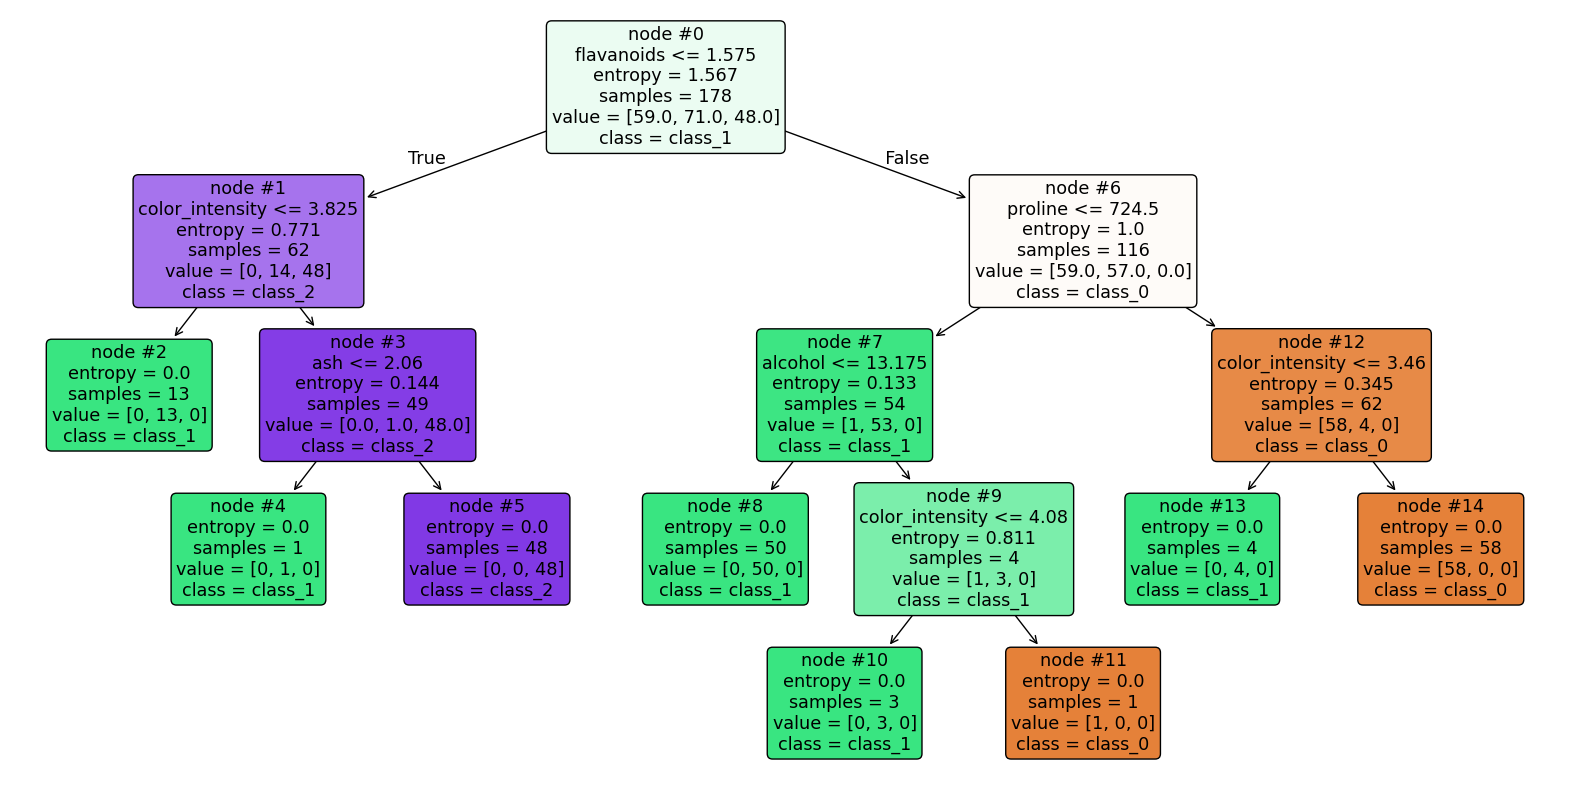

Cantidad total de nodos: 15
Cantidad de hojas: 8


In [20]:
clf = DecisionTreeClassifier(criterion='entropy')
clf.fit(X, y)

plt.figure(figsize=(20,10))
plot_tree(clf, feature_names=feature_names, class_names=class_names, filled=True, rounded=True, node_ids=True)
plt.show()

# Mostrar cantidad de nodos y hojas
print(f"Cantidad total de nodos: {clf.tree_.node_count}")
print(f"Cantidad de hojas: {sum(clf.tree_.children_left == -1)}")

🌳 **¿Qué representa este árbol?**

Cada nodo representa una condición lógica basada en una feature (característica) del dataset.

Los valores en cada nodo indican:

- feature <= umbral: condición de partición.
- entropy: medida de impureza del nodo.
- samples: cantidad de muestras que llegan a ese nodo.
- value = [c0, c1, c2]: cantidad de muestras por clase.
- class = class_X: clase mayoritaria en ese nodo.


3. Encontrar los **3 features más relevantes** según la **Feature Importance**.

- Las feature importances (importancias de características) indican cuánto contribuye cada feature (columna del dataset) a la construcción del árbol de decisión.

- La feature importance en un árbol de decisión está directamente relacionada con la entropía (si usás criterion='entropy') porque mide cuánta entropía logra reducir una feature cuando se la usa para dividir.

- Antes de una división, el nodo tiene cierta entropía, La feature seleccionada divide el nodo en dos hijos, se calcula la entropía ponderada de los hijos, la reducción de entropía se llama Information Gain, esta gain se acumula para cada feature cada vez que se la usa en un split.

- Una feature con mucha importancia es aquella que, al ser usada, produce una gran reducción de entropía.

- Si una feature no reduce entropía, no se usa en splits y su importancia es 0.


In [22]:
importances = clf.feature_importances_
indices = np.argsort(importances)[::-1]  # Orden descendente

# Seleccionar top 3
top_features = [(wine.feature_names[i], importances[i]) for i in indices[:3]]

# Formatear como markdown
markdown_text = "### 🏆 Top 3 features más importantes:\n"
for name, score in top_features:
    markdown_text += f"- **{name}**: {score:.4f}\n"

display(Markdown(markdown_text))

### 🏆 Top 3 features más importantes:
- **flavanoids**: 0.4128
- **proline**: 0.3134
- **color_intensity**: 0.2228



4. Clasificar el siguiente análisis químico:

```
13.0, 2.33, 2.37, 19.5, 99.7, 2.29, 2.03, 0.36, 1.59, 5.06, 0.96, 2.61, 747
```

In [23]:
nuevo_vino = np.array([[13.0, 2.33, 2.37, 19.5, 99.7, 2.29, 2.03, 0.36, 
                        1.59, 5.06, 0.96, 2.61, 747]])

# Clasificación
prediccion = clf.predict(nuevo_vino)[0]
clase = wine.target_names[prediccion]

# Mostrar resultado en Markdown
display(Markdown(f"### 🍷 El vino fue clasificado como: **{clase}** (clase {prediccion})"))

### 🍷 El vino fue clasificado como: **class_0** (clase 0)

____
## (c) Podado

Repetir el inciso (b) para un  árbol **podado** con una **complejidad α = 0.05**. Calcular el **costo-complejidad** asociado.


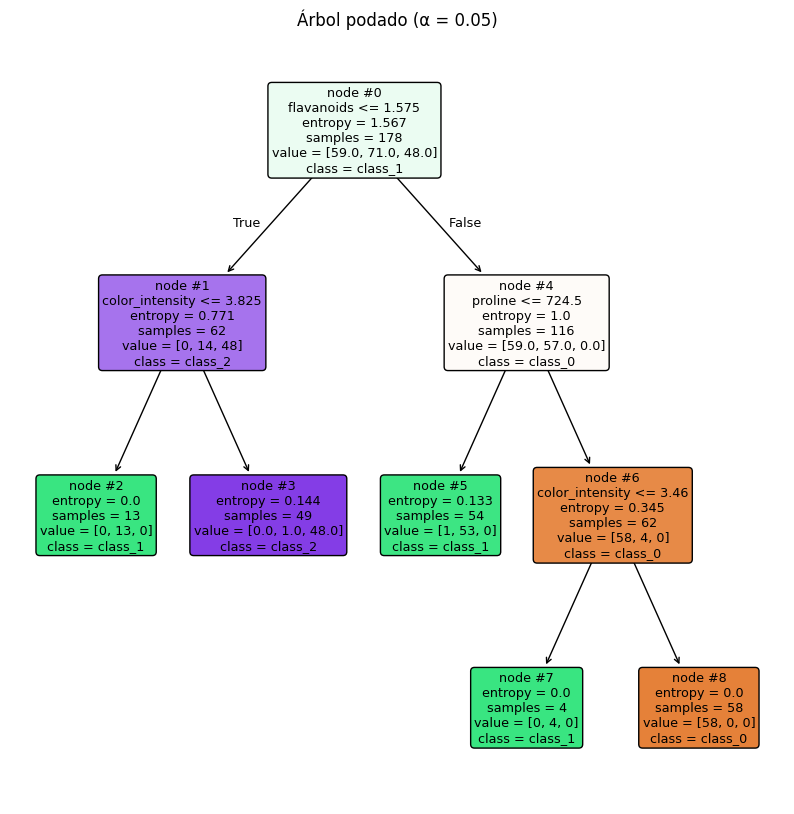


### 🌿 Árbol podado (α = 0.05)

- **Cantidad total de nodos**: 9  
- **Cantidad de hojas**: 5  
- **Clasificación del análisis químico**: **class_0** (clase 0)


In [ ]:
# Entrenar árbol podado con α = 0.05
alpha_target = 0.05
clf_podado = DecisionTreeClassifier(criterion='entropy', ccp_alpha=alpha_target)
clf_podado.fit(X, y)

# Graficar árbol podado
plt.figure(figsize=(10, 10))
plot_tree(clf_podado, feature_names=wine.feature_names, class_names=wine.target_names, filled=True,rounded=True, node_ids=True)
plt.title(f"Árbol podado (α = {alpha_target})")
plt.show()

# Mostrar nodos y hojas
n_nodos = clf_podado.tree_.node_count
n_hojas = sum(clf_podado.tree_.children_left == -1)

# Clasificar el análisis químico dado
nuevo_vino = np.array([[13.0, 2.33, 2.37, 19.5, 99.7, 2.29, 2.03, 0.36, 
                        1.59, 5.06, 0.96, 2.61, 747]])
prediccion = clf_podado.predict(nuevo_vino)[0]
clase = wine.target_names[prediccion]

# Mostrar resultados en Markdown
display(Markdown(f"""
### 🌿 Árbol podado (α = {alpha_target})

- **Cantidad total de nodos**: {n_nodos}  
- **Cantidad de hojas**: {n_hojas}  
- **Clasificación del análisis químico**: **{clase}** (clase {prediccion})
"""))


Se eliminaron nodos que aportaban muy poca mejora en entropía, especialmente donde había pocas muestras. Por ejemplo, nodos como el #9, #10, #11, #13, #14 del árbol anterior desaparecieron.

| Aspecto                    | Árbol sin podar           | Árbol podado (α = 0.05)      |
| -------------------------- | ------------------------- | ---------------------------- |
| 🌲 Nodos totales           | 15                        | 9                            |
| 🌿 Hojas                   | 8                         | 5                            |
| 🔄 Profundidad             | Mayor                     | Menor                        |
| 🎯 Precisión entrenamiento | Mayor (potencial overfit) | Menor pero más generalizable |
| ❌ Ramas eliminadas         | No                        | Sí, varias ramas podadas     |

- Cuanto más grande es ccp_alpha, más caro es tener muchos nodos.
- El algoritmo elimina ramas si su ganancia en precisión no justifica su costo en complejidad
- Si agregar un nodo no reduce suficientemente la entropía, se lo poda.

____
## (d) Bosques Aleatorios
Implementar un bosque aleatorio de 30  árboles (sin poda) con entropía como función de impureza. Puede utilizar el comando `tree.DecisionTreeClassifier` (sklearn), pero la combinación de estos  árboles debe ser implementación propia. El código debe estar estructurado de la siguiente manera:

```python
class RandomForest:

 # Inicializar atributos y declarar hiperparámetros
 def __init__(self, ...):

 # Etapa de entrenamiento
 def fit(self, X, y):

 # Etapa de testeo hard
 def predict(self, X):
```

Clasificar el mismo análisis químico dado en el punto (b).

Un **bosque aleatorio** es una colección de varios árboles de decisión independientes, entrenados sobre subconjuntos aleatorios de los datos y/o de las features. La predicción final se obtiene combinando sus resultados

| Característica       | Árbol de decisión único  | Árbol podado               | Bosque aleatorio                         |
| -------------------- | ------------------------ | -------------------------- | ---------------------------------------- |
| 🌲 Modelo base       | Un solo árbol            | Un solo árbol simplificado | 30 árboles independientes                |
| 🧠 Overfitting       | Alto (memoriza)          | Reducido por poda          | Muy bajo (promedia errores)              |
| 🔀 Variabilidad      | Nula                     | Nula                       | Alta: cada árbol ve un conjunto distinto |
| 📊 Robustez          | Depende del árbol        | Mejor que sin poda         | Mucho más robusto a ruido    |


Se realizo una implementación básica de un bosque aleatorio de 30 árboles (sin poda), utilizando DecisionTreeClassifier con entropía, y combinando las predicciones por votación mayoritaria (hard voting):


### 🌲 Random Forest (30 árboles)
- Clasificación: **class_1** (clase 1)

### 🌲 Visualizacion de alguno de los arboles generados

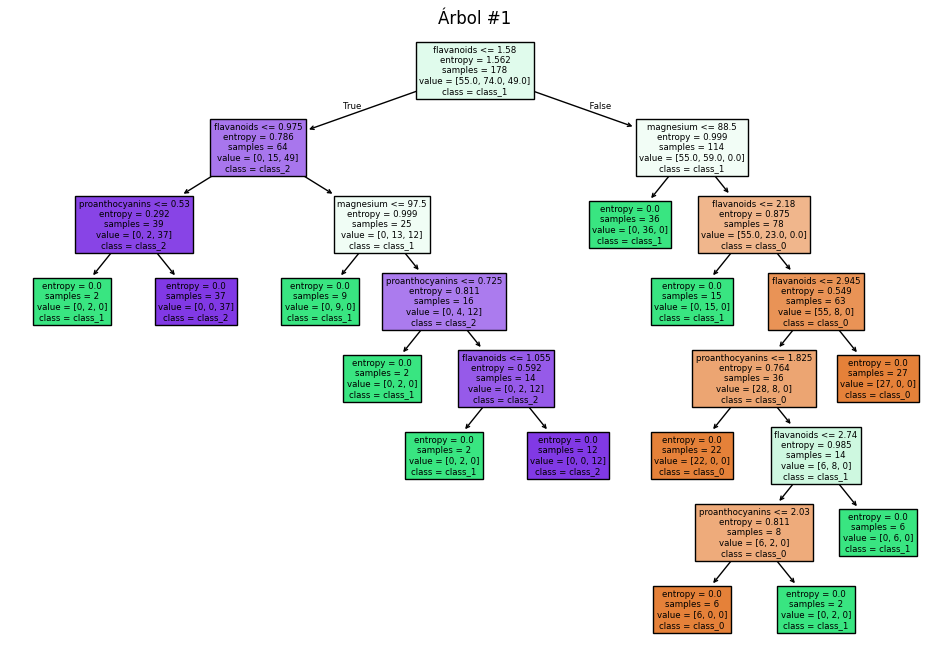

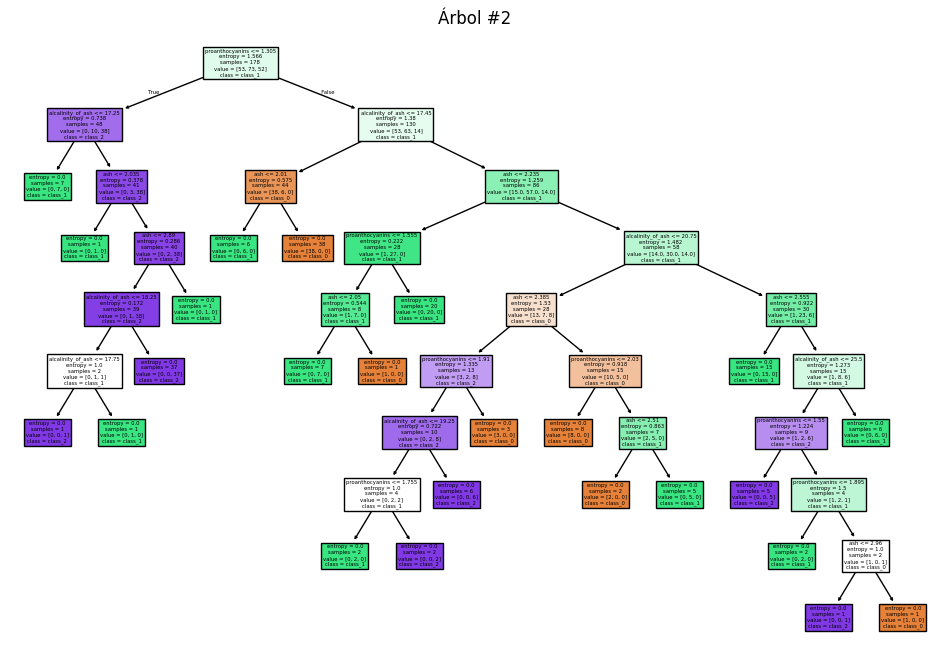

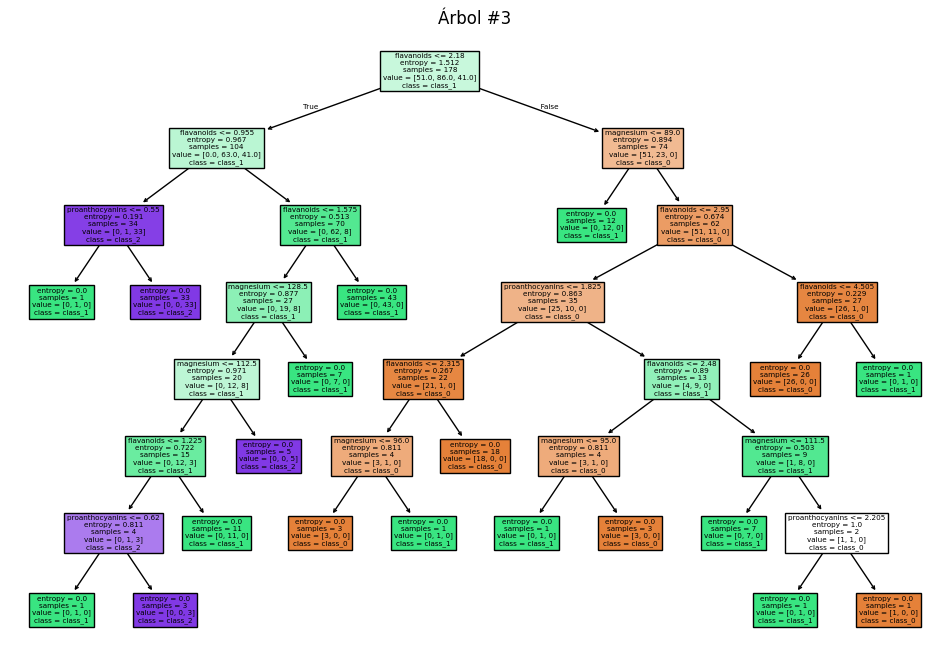

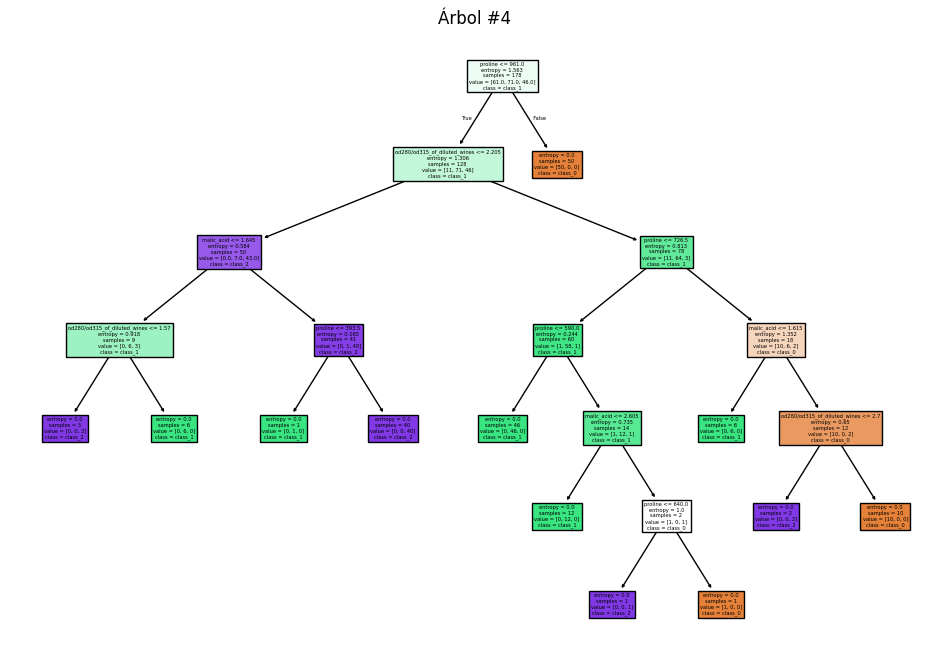

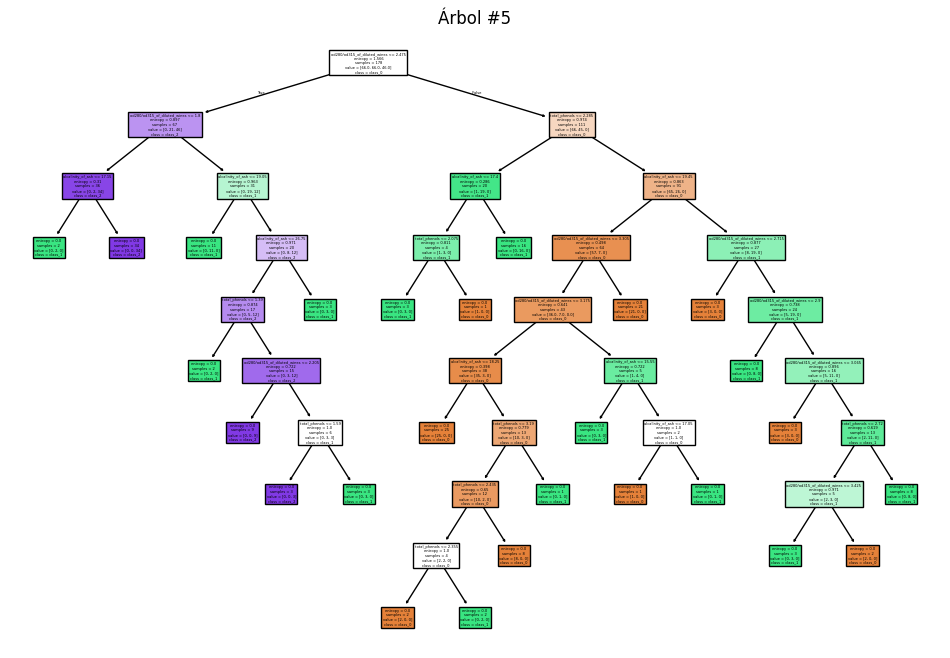

In [23]:
class RandomForest:
    def __init__(self, n_estimators=30, max_features='sqrt', criterion='entropy', random_state=0):
        self.n_estimators = n_estimators
        self.max_features = max_features
        self.criterion = criterion
        self.random_state = random_state
        self.trees = []
        self.features_indices = []

    def fit(self, X, y):
        rng = np.random.RandomState(self.random_state)
        n_samples, n_features = X.shape

        for i in range(self.n_estimators):
            # Bootstrap sample
            X_sample, y_sample = resample(X, y, random_state=rng.randint(0, 9999))

            # Seleccionar features aleatorias (sqrt por default)
            if self.max_features == 'sqrt':
                n_feats = int(np.sqrt(n_features))
            else:
                n_feats = n_features

            feats_idx = rng.choice(n_features, size=n_feats, replace=False)
            self.features_indices.append(feats_idx)

            # Entrenar árbol con features seleccionadas
            tree = DecisionTreeClassifier(criterion=self.criterion, random_state=rng.randint(0, 9999))
            tree.fit(X_sample[:, feats_idx], y_sample)
            self.trees.append(tree)

    def predict(self, X):
        predictions = np.array([
            tree.predict(X[:, feats])
            for tree, feats in zip(self.trees, self.features_indices)
        ])
        return mode(predictions, axis=0, keepdims=False).mode
    


# Entrenar el RandomForest
rf = RandomForest()
rf.fit(X, y)

# Clasificar nuevo vino
pred_rf = rf.predict(nuevo_vino)[0]
clase_rf = wine.target_names[pred_rf]

# Mostrar resultado
display(Markdown(f"### 🌲 Random Forest (30 árboles)\n- Clasificación: **{clase_rf}** (clase {pred_rf})"))

# Mostrar alguno de los arboles generados:
n_to_show = 5
display(Markdown(f"### 🌲 Visualizacion de alguno de los arboles generados"))

for i in range(n_to_show):
    tree = rf.trees[i]
    feats = rf.features_indices[i]
    feature_names = [wine.feature_names[j] for j in feats]
    
    plt.figure(figsize=(12, 8))
    plot_tree(tree, feature_names=feature_names, class_names=wine.target_names, filled=True)
    plt.title(f"Árbol #{i+1}")
    plt.show()

